# Monte‑Carlo Control – Modified Black Jack

In [1]:

import numpy as np, matplotlib.pyplot as plt, os
from tqdm import trange
from env import BlackjackEnv

np.random.seed(0)
env = BlackjackEnv()


### Helper functions

In [2]:

from collections import defaultdict

def epsilon_greedy(Q, state, N_state, N0=100):
    eps = N0 / (N0 + N_state[state])
    if np.random.rand() < eps:
        return np.random.randint(2)
    q_vals = Q[state]
    max_q = np.max(q_vals)
    return np.random.choice(np.flatnonzero(q_vals == max_q))

def state_key(state):
    return tuple(state)  # simple hashable key


### Training loop

In [3]:

num_episodes = 500_000   # adjust if runtime is tight
Q = defaultdict(lambda: np.zeros(2))
N_sa = defaultdict(int)
N_s = defaultdict(int)

for ep in trange(num_episodes):
    episode = []
    s = env.reset()
    done = False
    while not done:
        a = epsilon_greedy(Q, state_key(s), N_s)
        s_next, r, done = env.step(a)
        episode.append((s, a, r))
        if done:
            break
        s = s_next

    G = episode[-1][2]          # undiscounted terminal reward
    visited = set()
    for s,a,_ in episode:
        k = (state_key(s), a)
        if k in visited:
            continue
        visited.add(k)
        N_sa[k] += 1
        N_s[state_key(s)] += 1
        alpha = 1.0 / N_sa[k]
        Q[state_key(s)][a] += alpha * (G - Q[state_key(s)][a])


100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:23<00:00, 21245.74it/s]


### Save **Q★** and Plot **V★**

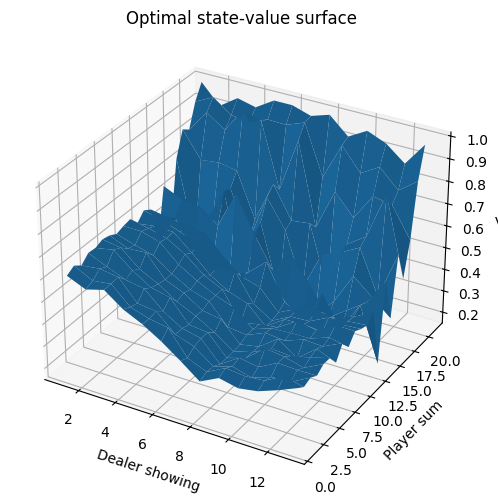

In [4]:

import numpy as np, matplotlib.pyplot as plt, os, math, itertools
import pickle, pathlib

# Save optimal Q as pickle (dictionary)
with open('mc_Q_star.pkl', 'wb') as f:
    pickle.dump(dict(Q), f)

# Build regular grid for plotting
dealer_vals = range(1, 14)     # 1–13
player_vals = range(1, 22)     # 1–21
X, Y = np.meshgrid(dealer_vals, player_vals)
Z = np.zeros_like(X, dtype=float)

for i,p_sum in enumerate(player_vals):
    for j,d_face in enumerate(dealer_vals):
        q_vals = Q.get((d_face, p_sum), np.zeros(2))
        Z[i,j] = np.max(q_vals)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlabel('V*')
plt.title('Optimal state‑value surface')
pathlib.Path('plots').mkdir(exist_ok=True)
plt.savefig('plots/v_star.png')
plt.show()
